In [337]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML, display, clear_output
from os import listdir
from nd2reader import ND2Reader
from ipywidgets import widgets, Layout

PATH = r'D:\Code\kural_work\actin_gan_data\\'

In [297]:
img_file = ND2Reader(PATH+'NDSequence001.nd2')

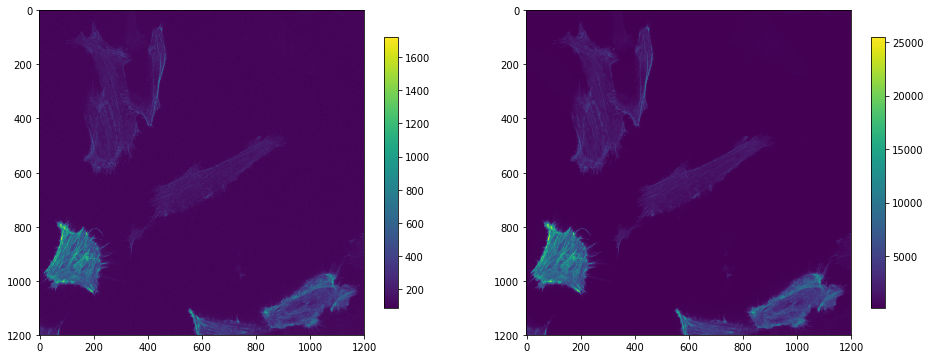

In [298]:
fig, ax = plt.subplots(1,2,figsize=(16,10))
for i in range(2):
    mappable = ax[i].imshow(img_file.get_frame_2D(c=i,v=0))
    plt.colorbar(mappable=mappable, ax=ax[i], shrink=0.5)

In [299]:
test_img = img_file.get_frame_2D(c=1,v=0)

In [305]:
test_img = torch.tensor(np.float32(test_img[8:-8,8:-8]))[None, None]

In [306]:
test_img.shape

torch.Size([1, 1, 1184, 1184])

In [321]:
test_img = (test_img-mini)/(maxi-mini)

In [324]:
test_out = model.features(test_img.cuda())

In [325]:
test_guess = np.zeros((34,34))
for i in range(34):
    for j in range(34):
        test_guess[i,j] = nn.Softmax(1)(model.classify(test_out[:,:,i:i+4,j:j+4].contiguous().view(1,128*4*4))).data.cpu().numpy()[0,1]

In [326]:
model.classify(test_out[:,:,i:i+4,j:j+4].contiguous().view(1,128*4*4))

tensor([[106.0896, 124.4962]], device='cuda:0', grad_fn=<AddmmBackward>)

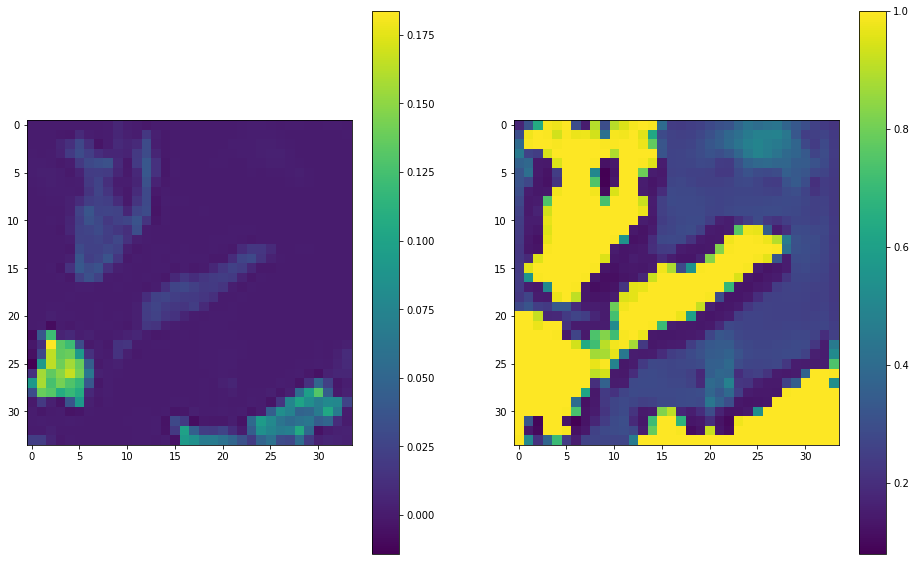

In [327]:
resized_img = np.array(Image.fromarray(test_img[0,0,:,:].data.numpy()).resize(size=(34,34),resample=Image.LANCZOS))
fig, ax = plt.subplots(1,2,figsize=(16,10))
m = ax[0].imshow(resized_img)
plt.colorbar(mappable=m, ax=ax[0])
m = ax[1].imshow(test_guess)
plt.colorbar(mappable=m, ax=ax[1])


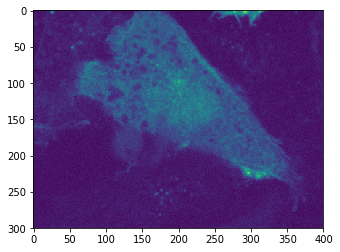

In [336]:
plt.imshow(test_img[0,0,:300,-500:-100])

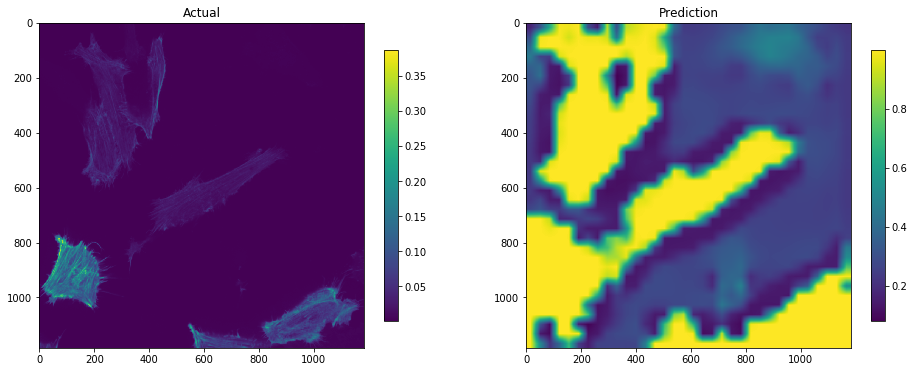

In [333]:
resized_img = np.array(Image.fromarray(test_guess).resize(size=(1184,1184),resample=Image.LINEAR))
fig, ax = plt.subplots(1,2,figsize=(16,10))
m = ax[0].imshow(test_img[0,0])
ax[0].set_title('Actual')
plt.colorbar(mappable=m, ax=ax[0],shrink=0.5)
m = ax[1].imshow(resized_img)
ax[1].set_title('Prediction')
plt.colorbar(mappable=m, ax=ax[1],shrink=0.5)
plt.show()

In [3]:
nf = len(img_file.metadata['fields_of_view'])
he = np.zeros((nf, 1, img_file.metadata['height'], img_file.metadata['width']),dtype=np.float32)
le = np.zeros((nf, 1, img_file.metadata['height'], img_file.metadata['width']),dtype=np.float32)
for f in range(nf):
    he[f,0] = img_file.get_frame_2D(c=1,v=f)
    le[f,0] = img_file.get_frame_2D(c=0,v=f)

In [4]:
he = torch.tensor(he)

In [5]:
le = torch.tensor(le)

In [6]:
with open(PATH+'he_le_tuple.pickle','wb') as f:
    pickle.dump((he,le),f,protocol=4)

In [2]:
with open(PATH+'he_le_tuple.pickle','rb') as f:
    he, le = pickle.load(f)

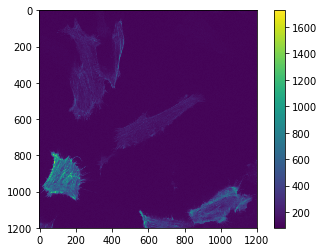

In [4]:
plt.imshow(le[0,0])
plt.colorbar()

In [5]:
ds = ActinGanDataset(he, le)

In [182]:
def display_actin():
    clear_output(wait=True)
    _, ax = plt.subplots(1,2,figsize=(16,10))
    idx = np.random.choice(len(ds))
    h,l = ds[idx]
    m = ax[0].imshow(h[0,0])
    plt.colorbar(mappable=m, ax=ax[0],shrink=0.5)
    m = ax[1].imshow(l[0,0])
    plt.colorbar(mappable=m, ax=ax[1],shrink=0.5)
    plt.show()
    def yes(btn):
        is_actin.append((h.clone().detach().data,l.clone().detach().data))
        print('Was actin!')
        display_actin()
    def no(btn):
        is_not_actin.append((h.clone().detach().data,l.clone().detach().data))
        print('Was not actin!')
        display_actin()
    y = widgets.Button(description='Yes, actin')
    y.on_click(yes)
    n = widgets.Button(description='No, not actin')
    n.on_click(no)
    w = widgets.HBox([y, n])
    display(w)

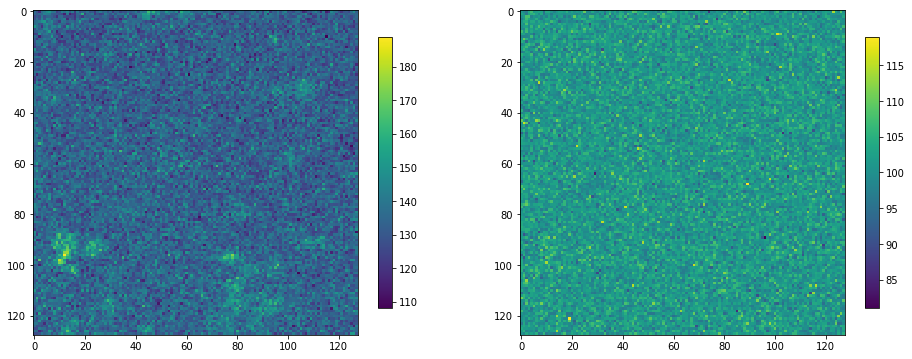

In [183]:
display_actin()

In [152]:
def yes(btn):
    is_actin.append((h.clone().detach().data,l.clone().detach().data))
    print('Was actin!')
    display_actin()
def no(btn):
    is_not_actin.append((h.clone().detach().data,l.clone().detach().data))
    print('Was not actin!')
    display_actin()
y = widgets.Button(description='Yes, actin')
y.on_click(yes)
n = widgets.Button(description='No, not actin')
n.on_click(no)
w = widgets.HBox([y, n])

In [206]:
is_actin = []
is_not_actin = []

In [119]:
len(is_not_actin)+len(is_actin)

1079

In [294]:
actin = (torch.cat([i for i,_ in is_actin]),torch.cat([j for _,j in is_actin]))
not_actin = (torch.cat([i for i,_ in is_not_actin]),torch.cat([j for _,j in is_not_actin]))

In [295]:
print((not_actin[0].shape[0],actin[0].shape[0]))

(810, 268)


In [296]:
with open(PATH+'actin_and_not_actin.pickle','wb') as f:
    pickle.dump((actin,not_actin),f,protocol=4)

In [3]:
with open(PATH+'actin_and_not_actin.pickle','rb') as f:
    actin, not_actin = pickle.load(f)

In [4]:
idx_order = np.random.permutation(actin[0].shape[0]+not_actin[0].shape[0])

In [5]:
na = actin[0].shape[0]
nna = not_actin[0].shape[0]
actin_class = list(range(0,na))
not_actin_class = list(range(na,na+nna))
all_actin = torch.cat([actin[0],not_actin[0]])
classification = []
imgs = []
for i in idx_order:
    imgs.append(all_actin[i])
    classification.append(torch.tensor(1) if i in actin_class else torch.tensor(0))

In [6]:
imgs = torch.stack(imgs)

In [7]:
classification = torch.stack(classification)

In [8]:
imgs.shape

torch.Size([1078, 1, 128, 128])

In [9]:
classification.shape

torch.Size([1078])

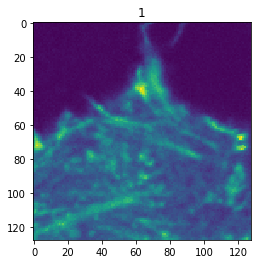

In [19]:
found = False
while not found:
    idx = np.random.choice(imgs.shape[0])
    if classification[idx] == 1: found=True
plt.imshow(imgs[idx,0])
plt.title(f'{classification[idx]}')
plt.show()

In [20]:
with open(PATH+'imgs_and_classification.pickle','wb') as f:
    pickle.dump((imgs,classification),f,protocol=4)

In [338]:
with open(PATH+'imgs_and_classification.pickle','rb') as f:
    imgs, classification = pickle.load(f)

In [339]:
mini = imgs.min()
maxi = imgs.max()
imgs = (imgs-mini)/(maxi-mini)


In [340]:
with open(PATH+'actin_classifier_model_image_normalization.pickle','wb') as f:
    pickle.dump((mini, maxi),f)

In [4]:
classification = classification.long()

In [106]:
ds = ActinClassifierDataset(imgs,classification)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 100
clip = 50
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True),drop_last=True)
val_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(val_idx),drop_last=True)
model = ActinClassifierModel().cuda()
opt = torch.optim.Adam(model.parameters(),lr=lr_start)
train_loss = []
val_loss = []
accuracy = []
criterion = nn.CrossEntropyLoss(weight=torch.tensor([.3,1], device = torch.device('cuda'), dtype=torch.float))

In [107]:
model, _tl, _vl, _acc = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-4, lr_end=1, epochs=5*2000, cycles=1, is_classification=True, lr_cycle='sin')
train_loss += _tl
val_loss += _vl
accuracy += _acc
torch.save(model.state_dict(),r'D:\Code\kural_work\actin_classifier_model.pth')
model, _tl, _vl, _acc = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-4, lr_end=1e-7, epochs=2000, cycles=1, is_classification=True, lr_cycle='cos')
train_loss += _tl
val_loss += _vl
accuracy += _acc
torch.save(model.state_dict(),r'D:\Code\kural_work\actin_classifier_model.pth')

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 62m 43s doing 2000 total steps for an average of 1.9s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


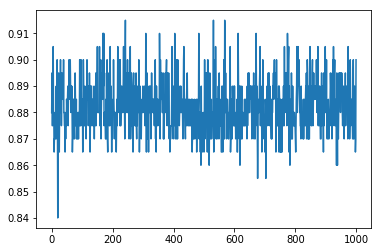

In [108]:
plt.plot(accuracy[-1000:])

In [37]:
lr_range = [1e-6*(10**(i/5)) for i in range(30)]
for lr in lr_range:
    model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=lr, lr_end=None, epochs=1, cycles=1)
    train_loss += _tl
    val_loss += _vl
    if _tl[0]>100: break

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 0m  2s doing 1 total steps for an average of 1.9s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


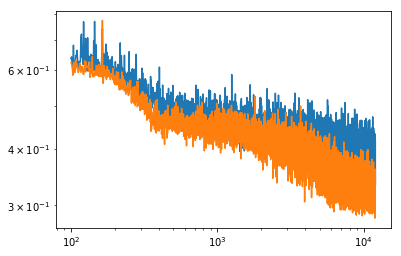

In [228]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(100,len(train_loss))
plt.plot(x[slc],train_loss[slc])
plt.plot(x[slc],val_loss[slc])
plt.xscale('log')
plt.yscale('log')
plt.show()

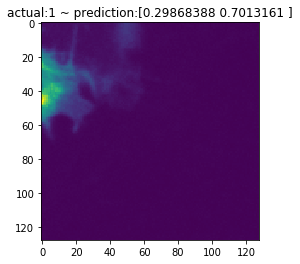

In [260]:
model.eval()
idx = np.random.choice(len(ds))
# _, ax = plt.subplots(1,2,figsize=[16,10])
i, c = ds[idx]
plt.imshow(i[0])
y_pred = nn.Softmax(1)(model(i[None].cuda())).cpu().data.numpy()
plt.title(f'actual:{c} ~ prediction:{y_pred[0]}')
plt.show()

In [262]:
nn.Softmax(1)(model(i[None].cuda())).cpu().data.numpy()

array([[0.8508422 , 0.14915784]], dtype=float32)

In [265]:
a_chance = []
img_list = []
a_true = []
model.eval()
for idx in range(len(ds)):
    i, c = ds[idx]
    y_pred = nn.Softmax(1)(model(i[None].cuda())).cpu().data.numpy()[0,1]
    img_list.append(i)
    a_chance.append(y_pred)
    a_true.append(c)

In [269]:
a_true = torch.stack(a_true)

tensor([0, 1, 0,  ..., 0, 0, 0])

In [270]:
a_true = a_true.data.numpy();a_true

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [271]:
a_chance = np.array(a_chance);a_chance

array([0.14915784, 0.9344963 , 0.1484649 , ..., 0.15068129, 0.14871387,
       0.14794993], dtype=float32)

In [273]:
img_list = torch.cat(img_list).data.numpy()

In [293]:
certain_true, certain_false, uncertain, wrong_true, wrong_false = ([] for _ in range(5))
for i in range(len(a_chance)):
    if a_true[i] == 1:
        if a_chance[i]>0.9:
            certain_true.append((a_chance[i],img_list[i]))
        if a_chance[i]<0.1:
            wrong_true.append((a_chance[i],img_list[i]))
        if a_chance[i]>0.45 and a_chance[i]<0.55:
            uncertain.append((a_chance[i],a_true[i],img_list[i]))
    if a_true[i] == 0:
        if a_chance[i]>0.5:
            wrong_false.append((a_chance[i],img_list[i]))
        if a_chance[i]<0.1:
            certain_false.append((a_chance[i],img_list[i]))
        if a_chance[i]>0.45 and a_chance[i]<0.55:
            uncertain.append((a_chance[i],a_true[i],img_list[i]))
print(len(certain_false), len(certain_true), len(uncertain), len(wrong_false), len(wrong_true))

0 103 26 45 0


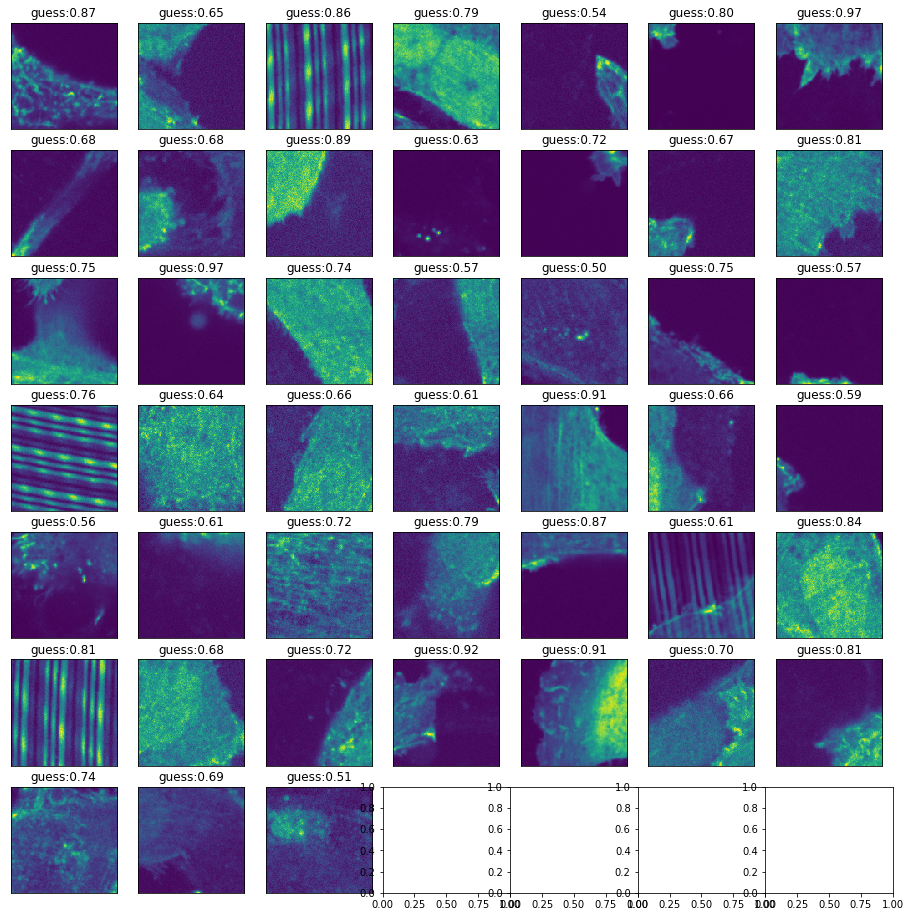

In [296]:
which_list = wrong_false
fig, ax = plt.subplots(7,7,figsize=(16,16))
ax = ax.flatten()
for j in range(len(which_list)):
    ax[j].imshow(which_list[j][1])
    ax[j].set_yticks([])
    ax[j].set_xticks([])
#     ax[j].set_title(f'actual:{which_list[j][1]} ~ guess:{which_list[j][0]:.2f}')
    ax[j].set_title(f'guess:{which_list[j][0]:.2f}')
fig.subplots_adjust(wspace=0,hspace=0.2)

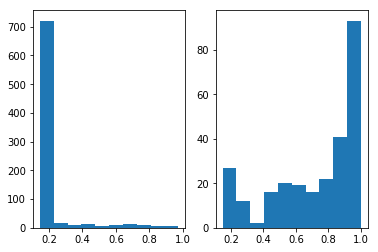

In [291]:
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(a_chance[a_true==i])
plt.show()

In [111]:
count = 0
for i in range(len(classification)):
    if classification[i]==1:
        count+=1
print(count/len(classification))

0.24860853432282004


In [234]:
params = model.parameters()
mods = model.modules()

In [235]:
p = 0
m = 0
for _ in model.parameters():
    p+=1
for _ in model.modules():
    m+=1

In [236]:
p,m

(44, 41)

In [223]:
p = next(params)
m = next(mods)

In [230]:
m = next(mods)

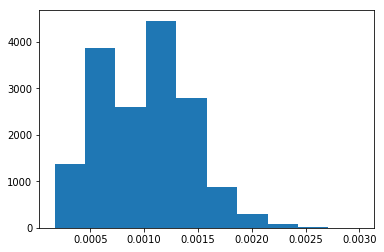

In [285]:
idx = np.random.choice(len(ds))
i, c = ds[idx]
plt.hist(i.flatten())
plt.show()

In [206]:
import time

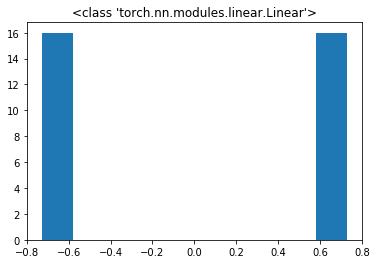

Press Enter to continue.


In [57]:
for m in model.modules():
    if not (isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear)): continue
    clear_output(True)
#     print(p)
    plt.hist(m.weight.grad.data.cpu().numpy().flatten())
    plt.title(type(m))
    plt.show()
    _ = input('Press Enter to continue.')

In [399]:
i = 0;
for m in model.modules():
    if isinstance(m, nn.Sequential):
        print(i)
        i+=1

0
1
2
3
4
5


In [401]:
m = list(model.modules())

In [443]:
m[9]

Sequential(
  (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
)

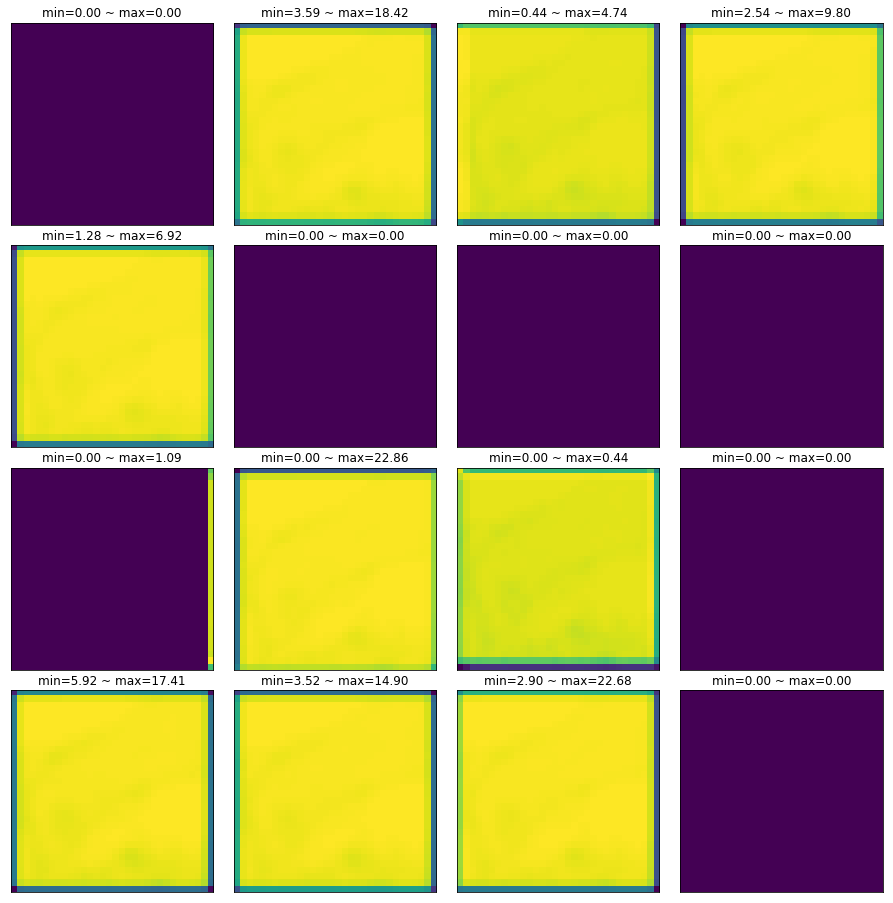

In [441]:
out = i[None].cuda()
for j in range(3,10):
    out = m[j](out)
fig, ax = plt.subplots(4,4,figsize=(16,16))
ax = ax.flatten()
for j in range(len(ax)):
    o = out[0,j].data.cpu()
    ax[j].imshow(o)
    ax[j].set_yticks([])
    ax[j].set_xticks([])
    ax[j].set_title(f'min={o.min():.2f} ~ max={o.max():.2f}')
fig.subplots_adjust(wspace=0,hspace=0.1)